## This notebook looks at plankton biogeography

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools
from scipy import stats
from cartopy.util import add_cyclic_point
from IPython.display import Image

### Define latest year and get the CESM data

In [20]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'
variables = ['diatC', 'coccoC','spC','diazC','zoo1C','zoo2C','zoo3C','zoo4C',
             'IFRAC','PD','Fe','diatChl','spChl','diazChl','coccoChl']
coords = {'x':'TLONG','y':'TLAT'}
keepthese = ['z_t','time_bound','TAREA','REGION_MASK', 'time'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']

In [21]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.annual.{v}.????-????.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004
diatC
coccoC
spC
diazC
zoo1C
zoo2C
zoo3C
zoo4C
IFRAC
PD
Fe
diatChl
spChl
diazChl
coccoChl
CPU times: user 10.3 s, sys: 3.41 s, total: 13.7 s
Wall time: 17.9 s


### Keep only the variables we need

In [22]:
variables = ['diatC', 'coccoC','spC','diazC',
            'zoo1C','zoo2C','zoo3C','zoo4C'] 
coords = {'x':'TLONG','y':'TLAT'}

In [23]:
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

In [25]:
ds=ds.isel(time=slice(2,61)).mean(dim='time')

In [26]:
ds_grid = pop_tools.get_grid('POP_gx1v7')

lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
depths=ds_grid.z_t * 0.01
area_m=area * 1.e-4
dz_m=ds_grid.dz * 0.01

### depth integrate biomass fields

In [27]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['zooC_TOT_zint'] = ds['zoo1C_zint'] + ds['zoo2C_zint'] + ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.spC * 10.
ds['spC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.coccoC * 10.
ds['coccoC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.diazC * 10.
ds['diazC_zint'] = tmp.sum(dim='z_t_150m')

ds['phytoC_TOT_zint'] = ds['spC_zint'] + ds['diatC_zint'] + ds['coccoC_zint'] + ds['diazC_zint']

In [28]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### zooC/phytoC ratio

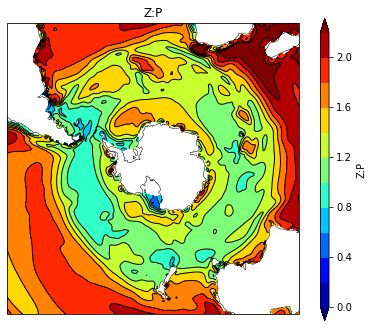

In [37]:
fig = plt.figure(figsize=(6,6))

######## zoo 4
contour_specs = {'levels': np.arange(0,2.4,0.2)}

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('Z:P')

lon,lat,field = adjust_pop_grid(lons, lats, z_to_p)
sh = lats[:, 0] < 0
lons_sh = lon[sh, :]
lats_sh = lat[sh, :]
field = field[sh, :]

cf = ax.contourf(lons_sh,lats_sh,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='both',**contour_specs)
cs = ax.contour(lons_sh,lats_sh,field, colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax,extend='max', label='Z:P');

### Zooplankton distribution (% zooplankton biomass)

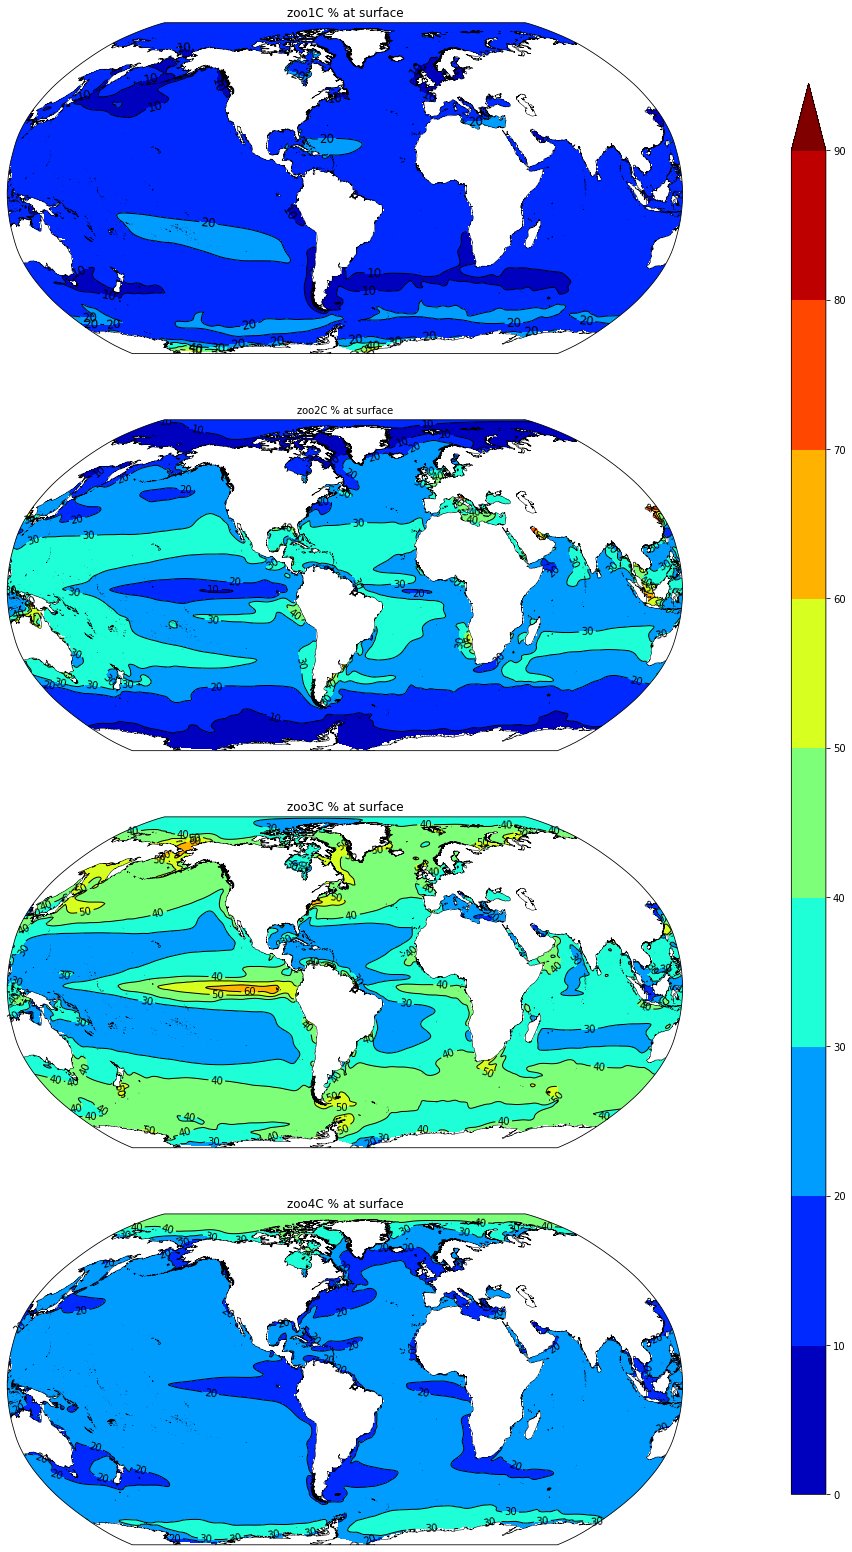

In [30]:
zooC = ds.zoo1C_zint + ds.zoo2C_zint + ds.zoo3C_zint + ds.zoo4C_zint
perc_zoo1 = ds.zoo1C_zint / (zooC) * 100.
perc_zoo2 = ds.zoo2C_zint / (zooC) * 100.
perc_zoo3 = ds.zoo3C_zint / (zooC) * 100.
perc_zoo4 = ds.zoo4C_zint / (zooC) * 100.

fig = plt.figure(figsize=(16,28))
contour_specs = {'levels': np.arange(0,100,10)}

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))

#### zoo1
ax.set_title('zoo1C % at surface', fontsize=12)

lon,lat,field = adjust_pop_grid(lons,lats,perc_zoo1)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='both',**contour_specs)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=12)

#### zoo2
ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo2C % at surface', fontsize=10)

lon,lat,field = adjust_pop_grid(lons,lats,perc_zoo2)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='both',**contour_specs)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=10)

### zoo3
ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo3C % at surface', fontsize=12)
lon,lat,field = adjust_pop_grid(lons,lats,perc_zoo3)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='both',**contour_specs)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=10)


### zoo3
ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo4C % at surface', fontsize=12)
lon,lat,field = adjust_pop_grid(lons,lats,perc_zoo4)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=10)

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(cf, cax=cbar_ax);

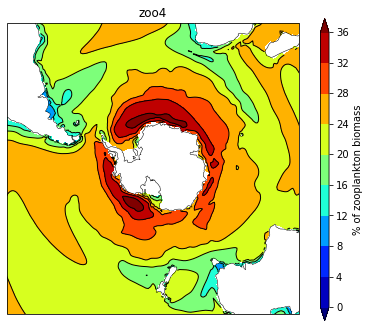

In [31]:
zooC = ds.zoo1C_zint + ds.zoo2C_zint + ds.zoo3C_zint + ds.zoo4C_zint
perc_zoo1 = ds.zoo1C_zint / (zooC) * 100.
perc_zoo2 = ds.zoo2C_zint / (zooC) * 100.
perc_zoo3 = ds.zoo3C_zint / (zooC) * 100.
perc_zoo4 = ds.zoo4C_zint / (zooC) * 100.


fig = plt.figure(figsize=(6,6))

######## zoo 4
contour_specs = {'levels': np.arange(0,40,4)}

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('zoo4')

lon,lat,field = adjust_pop_grid(lons, lats, perc_zoo4)
sh = lats[:, 0] < 0
lons_sh = lon[sh, :]
lats_sh = lat[sh, :]
field = field[sh, :]

cf = ax.contourf(lons_sh,lats_sh,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='both',**contour_specs)
cs = ax.contour(lons_sh,lats_sh,field, colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax,extend='max', label='% of zooplankton biomass');

In [32]:
bioC = zooC + ds.coccoC_zint + ds.spC_zint + ds.diatC_zint + ds.diazC_zint
perc_zoo1 = ds.zoo1C_zint / (bioC) * 100.
perc_zoo2 = ds.zoo2C_zint / (bioC) * 100.
perc_zoo3 = ds.zoo3C_zint / (bioC) * 100.
perc_zoo4 = ds.zoo4C_zint / (bioC) * 100.

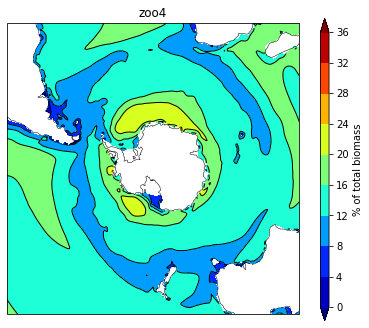

In [33]:
fig = plt.figure(figsize=(6,6))

######## zoo 4
contour_specs = {'levels': np.arange(0,40,4)}

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('zoo4')

lon,lat,field = adjust_pop_grid(lons, lats, perc_zoo4)
sh = lats[:, 0] < 0
lons_sh = lon[sh, :]
lats_sh = lat[sh, :]
field = field[sh, :]

cf = ax.contourf(lons_sh,lats_sh,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='both',**contour_specs)
cs = ax.contour(lons_sh,lats_sh,field, colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax,extend='max', label='% of total biomass');

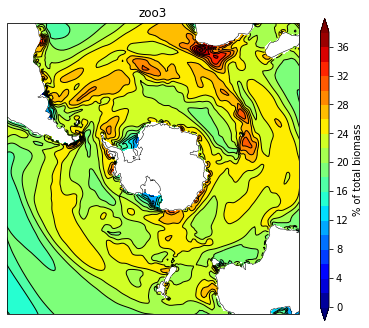

In [34]:
fig = plt.figure(figsize=(6,6))

######## zoo 4
contour_specs = {'levels': np.arange(0,40,2)}

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('zoo3')

lon,lat,field = adjust_pop_grid(lons, lats, perc_zoo3)
sh = lats[:, 0] < 0
lons_sh = lon[sh, :]
lats_sh = lat[sh, :]
field = field[sh, :]

cf = ax.contourf(lons_sh,lats_sh,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='both',**contour_specs)
cs = ax.contour(lons_sh,lats_sh,field, colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax,extend='max', label='% of total biomass');

### Percent of phytoplankton 

In [38]:
phytoC = ds.coccoC_zint + ds.spC_zint + ds.diatC_zint + ds.diazC_zint
perc_spC = ds.spC_zint / (phytoC) * 100.
perc_coccoC = ds.coccoC_zint / (phytoC) * 100.
perc_diatC = ds.diatC_zint / (phytoC) * 100.
perc_diazC = ds.diazC_zint / (phytoC) * 100.

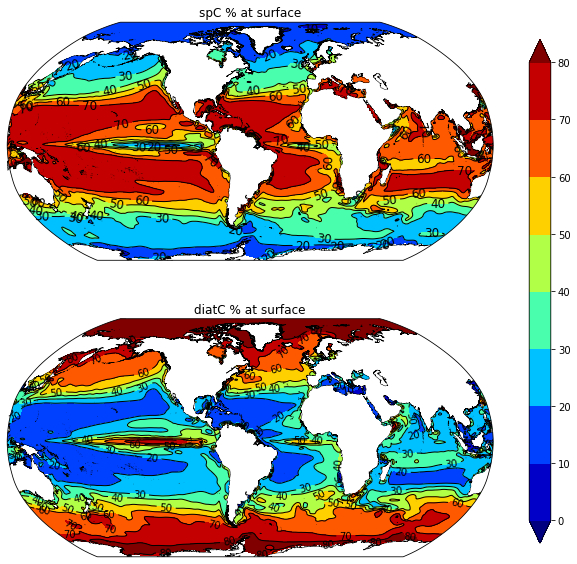

In [44]:
fig = plt.figure(figsize=(10,10))
contour_specs = {'levels': np.arange(0,90,10)}

ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))

#### sp
ax.set_title('spC % at surface', fontsize=12)

lon,lat,field = adjust_pop_grid(lons,lats,perc_spC)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='both',**contour_specs)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=12)

### diat
ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC % at surface', fontsize=12)
lon,lat,field = adjust_pop_grid(lons,lats,perc_diatC)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='both',**contour_specs)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=10)



### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(cf, cax=cbar_ax);

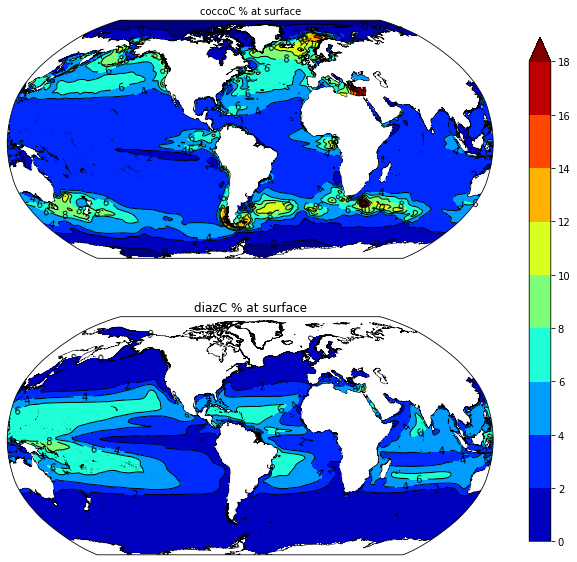

In [45]:
fig = plt.figure(figsize=(10,10))
contour_specs = {'levels': np.arange(0,20,2)}


#### cocco
ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC % at surface', fontsize=10)

lon,lat,field = adjust_pop_grid(lons,lats,perc_coccoC)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='both',**contour_specs)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=10)


### diaz
ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC % at surface', fontsize=12)
lon,lat,field = adjust_pop_grid(lons,lats,perc_diazC)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=10)

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(cf, cax=cbar_ax);

### HTL food (zoo3 + zoo4)

In [50]:
HTL_food = ds.zoo3C_zint + ds.zoo4C_zint
HTL_food = HTL_food.where(ds.spC.isel(z_t_150m=0) > -1000.)

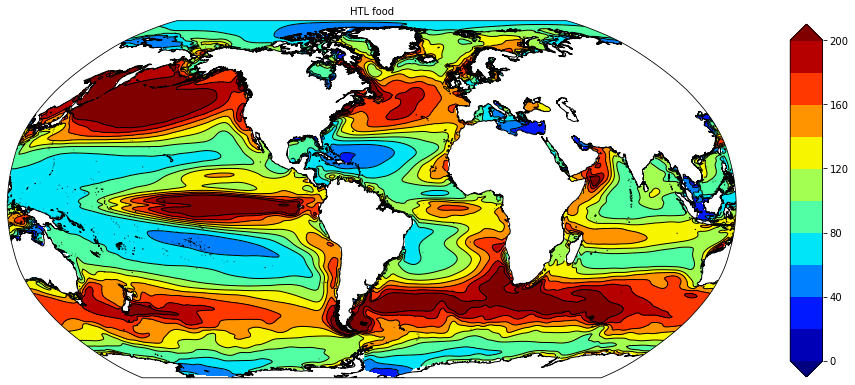

In [54]:
fig = plt.figure(figsize=(15,7))
contour_specs = {'levels': np.arange(0,220,20)}

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('HTL food', fontsize=10)

lon,lat,field = adjust_pop_grid(lons,lats,HTL_food)
cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='both',**contour_specs)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)
#plt.clabel(cs, colors = 'black', fmt = '%2.0f', fontsize=10)

### color base
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(cf, cax=cbar_ax);